<a href="https://colab.research.google.com/github/RodrigoRoman/machine_learning_abc/blob/main/hole_filling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h3>Importamos librerias</h3>

In [ ]:
import cv2
import urllib
import numpy as np
from PIL import Image, ImageOps
import matplotlib.pyplot as plt


<h2>b) Investigar una aplicación de dilatación en procesamiento de imágenes e implementarlo en Colab
</h2>
<h3>Llenado de agujeros.</h3>
<p>El llenado de agujeros es un proceso importante en la corrección de imágenes binarias, especialmente en el ámbito médico, donde las imágenes se convierten en binarias mediante el uso de un umbral. Sin embargo, en ocasiones, una selección inadecuada del límite puede resultar en la presencia de regiones de fondo (pixeles con valor 0) dentro de regiones de frente (pixeles con valor 1), generando así agujeros indeseados en la imagen.

El proceso de llenado de agujeros consiste en utilizar una operación morfológica, en este caso, la dilatación. La idea es encontrar un punto dentro del agujero a llenar y a partir de allí, aplicar dilatación recursiva con la condición de que cada elemento que se vaya a cambiar también se encuentre en el complemento de la imagen. Una vez que ya no se pueden realizar más cambios, se combina la imagen dilatada con la original para lograr una imagen sin agujeros.

En un ejemplo básico, supongamos que un punto dentro del orificio estaba previamente definido. En este caso, el algoritmo de llenado de agujeros utiliza la dilatación recursiva para expandir ese punto hacia el exterior, hasta cubrir completamente el agujero, utilizando la condición mencionada previamente. De esta forma, se logra una imagen más precisa y sin agujeros indeseados.</p>

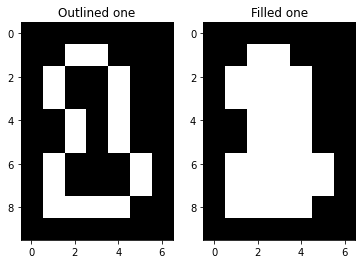

[[0 0 0 0 0 0 0]
 [0 0 1 1 0 0 0]
 [0 1 1 1 1 0 0]
 [0 1 1 1 1 0 0]
 [0 0 1 1 1 0 0]
 [0 0 1 1 1 0 0]
 [0 1 1 1 1 1 0]
 [0 1 1 1 1 1 0]
 [0 1 1 1 1 0 0]
 [0 0 0 0 0 0 0]]


In [ ]:
#Implementacion de dilatacion para llenar orificios

# Definimos la funcion que regresa el objeto sin orificios
def fillHoles(img,start_x,start_y):

  # Calculamos el complemento de la imagen para usarlo como condicional
  complement_image = 1-img

  # Creamos un array para guardar la imagen resultante sin orificios
  filledImage = np.zeros(img.shape)

  # Convertimos el elemento en el que empezamos en 1
  filledImage[start_y,start_x] = 1

  # Definimos nuestro SE
  SE = np.array([[0,1,0],
                 [1,0,1],
                 [0,1,0]
                 ])
  
  # Asumimos que la imagen ingresa a la funcion con un padding de 1
  padd = 1
  current_filled = filledImage.copy()
  while True:
    for y in range(img.shape[0]-2):
        for x in range(img.shape[1]-2):
          windowimage = filledImage[y:y+(padd*3),x:x+(padd*3)]
          if((True in np.logical_and(windowimage,SE)) and (complement_image[y+padd,x+padd] == 1)):
            current_filled[y+padd,x+padd] = 1
    if(np.count_nonzero(current_filled == 1) == np.count_nonzero(filledImage == 1)):
      break
    else:
      filledImage = current_filled.copy()
  union = np.logical_or(filledImage,img)
  return union*1




# Tomemos el ejemplo del libro de Gonzales
outlinedOne = np.array([
    [0,0,0,0,0,0,0],
    [0,0,1,1,0,0,0],
    [0,1,0,0,1,0,0],
    [0,1,0,0,1,0,0],
    [0,0,1,0,1,0,0],
    [0,0,1,0,1,0,0],
    [0,1,0,0,0,1,0],
    [0,1,0,0,0,1,0],
    [0,1,1,1,1,0,0],
    [0,0,0,0,0,0,0]
])

start_x,start_y = (3,3)
filledImage = fillHoles(outlinedOne,3,3)

plt.subplot(121)
plt.imshow(outlinedOne, cmap='gray')
plt.title('Outlined one')


plt.subplot(122)
plt.imshow(filledImage, cmap='gray')
plt.title('Filled one')


plt.show()
print(filledImage)

<p>A continuación nos apoyamos de la función finContours para ubicar la presencia de orificios . Una vez que estos son localizados, se aplica un algoritmo simplificado para encontrar un punto específico dentro de ellos. Este punto seleccionado se utiliza como base para aplicar el algoritmo previamente establecido y lograr el llenado de todos los orificios de la imagen.</p>

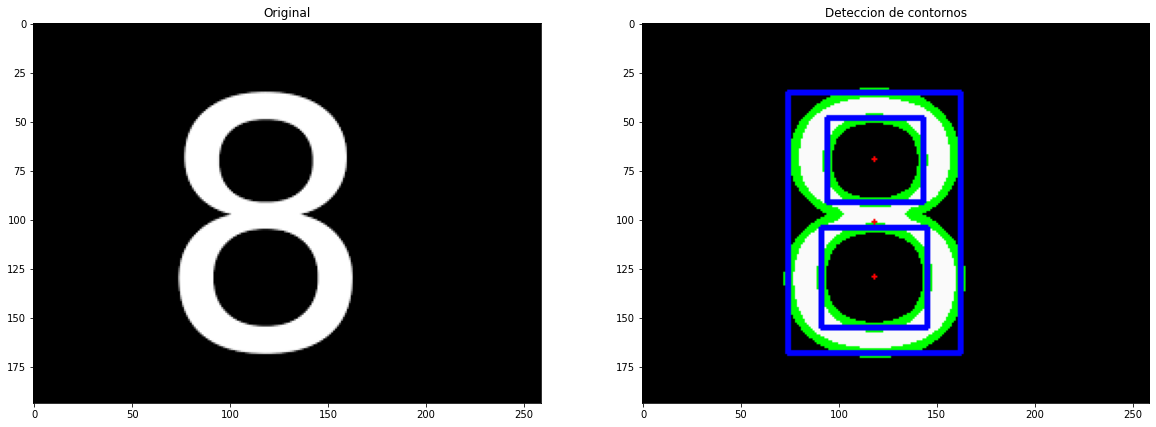

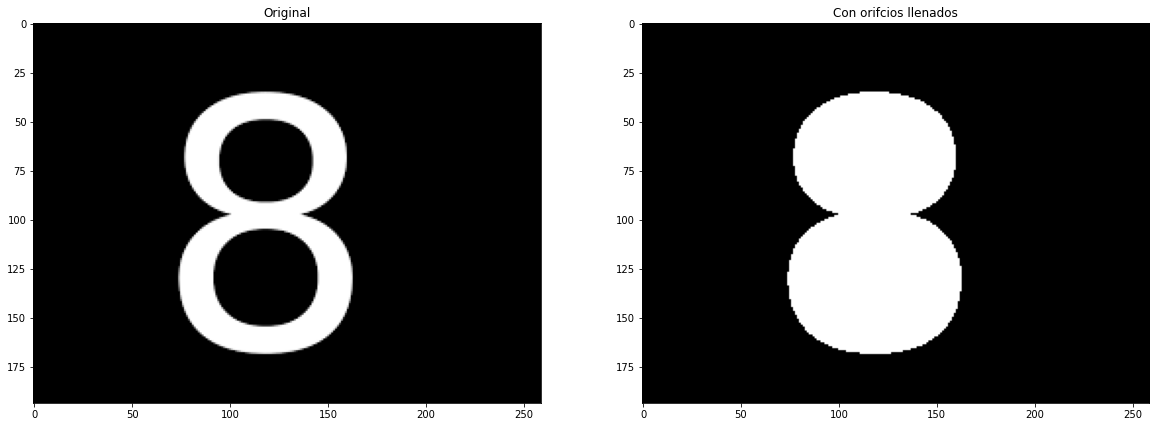

In [ ]:
import cv2

# Cargamos la imagen
url =  'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTWpmsqQi9fu6RF_8zrap51IAHQpF05lDs_yw&usqp=CAU'
urllib.request.urlretrieve(url, "image_holes.jpg")
img = cv2.imread("image_holes.jpg")

# Binarizamos la imagen
threshold = 100
BGR2GRAY = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
binr = cv2.threshold(BGR2GRAY, threshold, 250, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
image = cv2.cvtColor(binr, cv2.COLOR_BGR2RGB)

def fill_holes_without_center(input_image):

  # Encontramos los contornos
  contours, hierarchy = cv2.findContours(binr, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)

  # Creamos una copia de la imagen para poder modificarla
  img_contours = image.copy()

  #Aplicamos a esta imagen el despliegue de contornos
  cv2.drawContours(img_contours, contours, -1, (0, 255, 0), 3)


  centers_dimensions = []
  for i, contour in enumerate(contours):
      # Calculate the minimum bounding rectangle of the contour
      rect = cv2.minAreaRect(contour)
      box = cv2.boxPoints(rect)

      box = np.int0(box)

      # Dibujamos el rectangulo del contorno
      cv2.drawContours(img_contours, [box], 0, (0, 0, 255), 2)

      # Calculamos su centro
      center = (int(rect[0][0]), int(rect[0][1]))
      centers_dimensions.append([center,box])

      # Dibujamos el centro del contorno
      cv2.circle(img_contours, center, 1, (255, 0, 0), -1)

  # Creamos version llenada de la imagen
  filled_image = binr.copy()
  for i in centers_dimensions:
    center_x,center_y = i[0]
  
    # Definimos las dimensiones del rectangulo que cubre el orificio
    bottom = min(i[1][0][1],i[1][1][1],i[1][2][1],i[1][3][1])-1
    top = max(i[1][0][1],i[1][1][1],i[1][2][1],i[1][3][1])+1
    left = min(i[1][0][0],i[1][1][0],i[1][2][0],i[1][3][0])-1
    right = max(i[1][0][0],i[1][1][0],i[1][2][0],i[1][3][0])+1

    # Llenamos el orificio y lo asignamos a la imagen saliente
    filled_image[bottom:top,left:right] = fillHoles(filled_image[bottom:top,left:right],(right-left)//2,(top-bottom)//2)

  return (img_contours,filled_image)

img_contours,filled_image = fill_holes_without_center(image)

# Desplegamos las imagenes

fig = plt.figure(figsize=(20, 20))
plt.subplot(2,2,1)
plt.imshow(img, cmap='gray')
plt.title('Original')

plt.subplot(2,2,2)
plt.imshow(img_contours, cmap='gray')
plt.title('Deteccion de contornos')

fig = plt.figure(figsize=(20, 20))
plt.subplot(2,2,3)
plt.imshow(img, cmap='gray')
plt.title('Original')

plt.subplot(2,2,4)
plt.imshow(filled_image, cmap='gray')
plt.title('Con orifcios llenados')

plt.show()



<p>Realizamos un ejemplo un poco mas complejo</p>

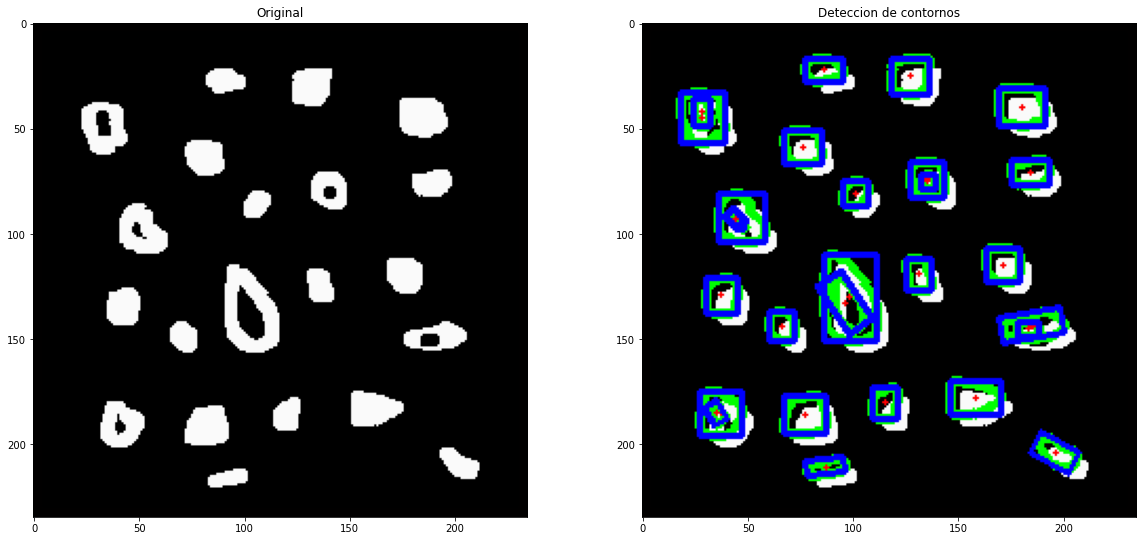

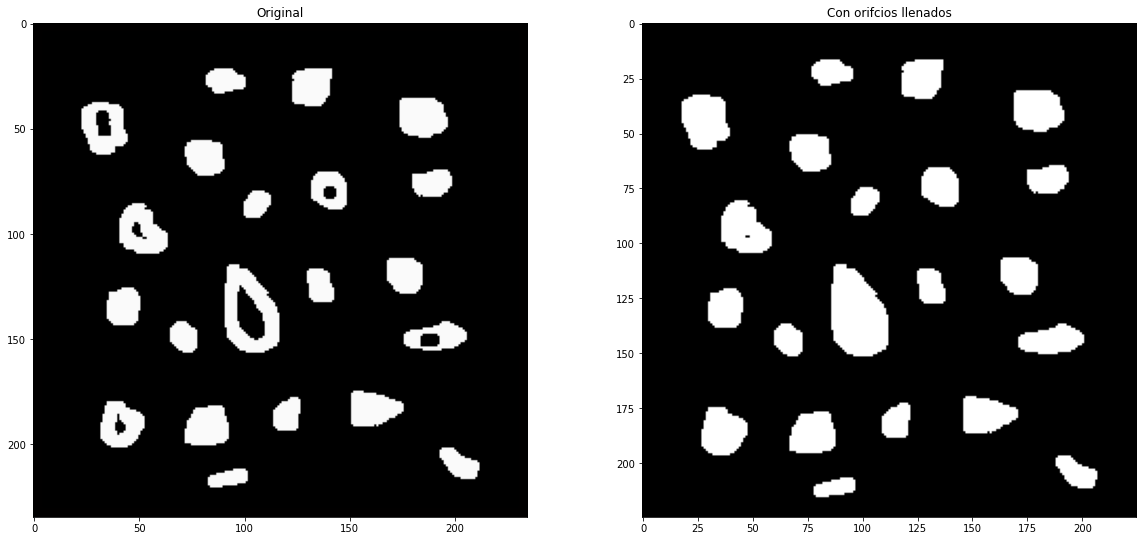

In [ ]:
#Cargamos la imagen
url = 'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcThsnQ8kp47G9lPGutcHKawDjlaK5wCw3vuDXEeJcklk9oE8V8ZQOXXpgmj4f-LortN924&usqp=CAU'

urllib.request.urlretrieve(url, "image_holes2.jpg")
img = cv2.imread("image_holes2.jpg")

# Binarizamos la imagen
threshold = 220
BGR2GRAY = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
binr = cv2.threshold(BGR2GRAY, threshold, 250, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
image = cv2.cvtColor(binr, cv2.COLOR_BGR2RGB)

img_contours,filled_image = fill_holes_without_center(image)

fig = plt.figure(figsize=(20, 20))
plt.subplot(2,2,1)
plt.imshow(image, cmap='gray')
plt.title('Original')

plt.subplot(2,2,2)
plt.imshow(img_contours, cmap='gray')
plt.title('Deteccion de contornos')

fig = plt.figure(figsize=(20, 20))
plt.subplot(2,2,3)
plt.imshow(image, cmap='gray')
plt.title('Original')

plt.subplot(2,2,4)
plt.imshow(filled_image, cmap='gray')
plt.title('Con orifcios llenados')

plt.show()

<p>Por ultimo lo aplicamos a una imagen medica</p>

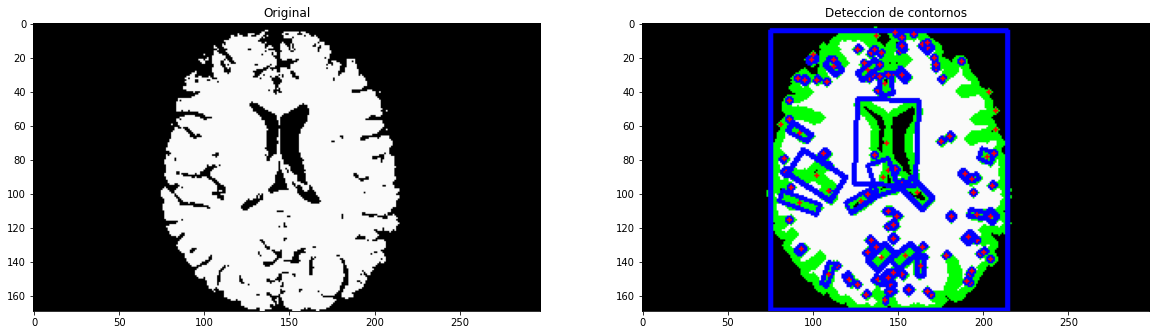

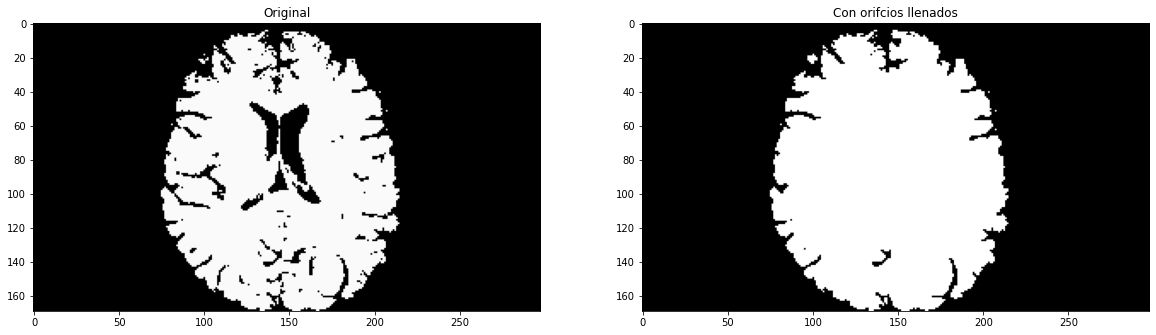

In [ ]:
#Cargamos la imagen
url = 'data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wCEAAoHCBUVFRgVFhYZGRYZHBkcHRocHRoeHBwdHSEcHhweIx4eIS4lHB8rHxgaJjgmKy8xNTU1GiQ7QDs0Py40NTEBDAwMBgYGEAYGEDEdFh0xMTExMTExMTExMTExMTExMTExMTExMTExMTExMTExMTExMTExMTExMTExMTExMTExMf/AABEIAKkBKgMBIgACEQEDEQH/xAAbAAEAAwADAQAAAAAAAAAAAAAABAUGAQMHAv/EADoQAAEDAQcCAwcDAwMFAQAAAAEAAhEDBAUSITFBUWFxBiKBEzJCkaGxwVLR8GLh8QcUchUjQ4KyM//EABQBAQAAAAAAAAAAAAAAAAAAAAD/xAAUEQEAAAAAAAAAAAAAAAAAAAAA/9oADAMBAAIRAxEAPwDxlERAREQFOZoOwUFTmaDsEHKIiAiIgIiICIrGz3eWllR8FhImPhJ0lBFsdkdUJDdtTsOPnCksumpiILRplnkt1YbAx1PE0jEDmNilao1pzYJ66fJBjrDcrzixxptoOuJQbbZ2sqBkktMawCJ+69DtdkFWljbLMOZA0PVYa8Ltc1weDILhMnNvU8oJLLrLxLcDWu2gk9DO3ZcVPDr2x5gd8wQPmFZU7KWtaGuIGU/2WnuqytcwOJnpxtCDzyvdhaDLHAjg4gf7KtIXqN9U2MDQ1gBIJJ1iNe6xt73PiBqMMEZkHf8AZBn0XLWy0mRlqN+/ZCIQcIiICIiAiIgKC7UqcoLtSg4REQEREBERAREQEREBTmaDsFBU5mg7BByiIgIiICIrKwXS6qJPlZuf1Rx2QT2XfTbTLsnZE4t9NOit6Nnb7BuIZQB8ws9/tKlMua0nCdAdDPHVbK6abKlEsAzIkTrLdR0QdNy2k0n4HTgdkD+O4laipYmPzLQOvPp1WWu+yPc/A4ZSPlz+Fr7RLGOcBk1uQ1hBX3pR8gY1zWwRlMT6LP3lZg1kYgThMgaR+6iVq9R9QhoGkueZP+T0Xfb7NDHY3lsskmQInQk/COiDpo3rRDGtMOOctznLXRaW5Lex3kwYZ90iYj1z9VmrPc7GMD2s8zCM/ixRI15V3cNtZiEtBMxO7Z2P4QXl4XeKse7H0hZW/ThmmwQAMIOWZ3cVucGcYTH83Wct13U2OxveXTMMiD68BB5lbbpcwtB0JAB5PXoplpuV7Kcuc0kaROU7SdR9lprVZTWqMaxsNDgct+ndTb7uxwo4dQQ4EjaUHmccopdrsrmziHmZqf1DQFREBERAREQFBdqVOUF2pQcIiICIiAiIgIiICIiApzNB2CgqczQdgg5REQEREHbZmAuk+6Myt7YKbCyMYE5BwzEDqspdt1uqtDQS0akjMkn3cjoAM1oLv8PPZAxPcNhoIQXFmuvEQMQc3oc1a2O5gx+MEiNgNeJ5XXd1gDQNQZmOn5V+0DeB+yCOyytxSAATkTv8+VKZTEFpGuvbTsvkM4Iy/n2XFotgpgudGAfblBVs8Nta/FJIGYEb8LK+LrOx2M4gSHgCTlJ+HNeh3XelG0Nmm9jw3XCfMCdJacwvmvctmrAY6YmQ7bVpy9ZQZHw5ZwYZiDgW75lw/dXVHw8xr8YnaRAGQ665FXtmu6iweSk1pnPKBG8cL7tFqpsEvc1mjRJiJ4+yCJUe3c5HKeFDtNlp1xhdkWgwW/WRuoFvtJe7ykjWI0I6Su65rM8u8ztIIkTAP2QSqF1CkwhmUiMR970VLbbRRs4c178TvixODQJ7rYPpDjbrr0VHe92WcuxVG+b5/dB5ne721XA0Wl+EkOLc24TqMWhWer0cJG4OYP0M8EFevtsdNwhgIkSCenZeeeIrCWOMGQ4lwHBbGL5iD6IM+iIgIiICgu1KnKC7UoOEREBERAREQEREBERAU5mg7BQVOZoOwQcoiICIiDT3ReJYcDWFz8LSC2I93eVbC8bQCXYHQRl524vkq+5LLUbLw0FhDBy6WgZ9lo7tvRj3Fj6eEt1BADgOcsiEHTYvEznGCHNcNQ8YfkRqrynfLXDg9D9lxRumjVdLH58ZSOcyvm33eym1pjUkcIJdC1B4LoOvzjspdvptNFrHiS4HXSDz+F93FZAGZCJ1n7KwvNgc1uUFsjjI79YQeN3tdFaxP9rSc7BikPbLS3+kjdvdbHwz/qEHuZRtLIeSGtqNyaSeRtPKt7TZQ8FjxjadZAzEffdeT1rN7KsWg+68AkczkfxCD0rxJ/qFToudTotL6okFx9xrhtO/2Xml83paLS8vrVHH+kZYJ6L4t5l7yRniOQ11zXddF3GvVawSGyS4k6DftKDYXC9xo0y+ScBz5G30WzuQFozADjmBnJH7Ku/6bADWAw1rW9gNPoplkqNZ5Nztnl67IL7TIiNchtxnsQodaACekS4CBzquhl4tmDmcpzy4S8GNqMc3HGhxcZ/ZBS3pftOkJEEDKTkPTcrH33b6NRzHNLSSTABkyR5s9lqH3LQEufUY4g/8vvust4io0fKGBuPEMOQadwSTxCDDBcpGo4JHyMIgIiICgu1KnKC7UoOEREBERAREQEREBERAU5mg7BQVOZoOwQcoiIC+7PSL3tYPiIH7/RfCsrhpOdWBaAS0EgHSdB+UHolhpeyY3yy3IaZEBfV63AahbUoFwIIPlIkcg9FNuu1sd/23jC7jWP7K3slkLHEA+V2n+EEC4bnfScHucTA0cQXfTaFJvG2MnBgxyR/xHAncr4va0VmOwsBwxIOWZ3njsqFtd7nhhYW5A43HImdRGiDYWclrJiBlkNv5KtPZ4mFrgHDKJ1HWZyVfZmAtzE56g+kyVYUJAyMxlJiCfTXJBT2rIHPIHONRx2XkFtBdaXE6Gptr723ovaPEFncWFzG6A4sOX9yTovL7ouN1otYDMmNqNJxfDBl4ncoM9eLS2q8ETD3Dr0+61H+nVIl9UugGGtAynXrqFR+I6eC01mkyC8wRwTlB9Fc+A7Q1toc13xsyn9Q39UHplipOzPwwcRnQdOvVZ6+bURo0u1iJAI2dO/qtddkhrx1H/tzrsFAtt3B3+YkfhBhrAKpe0yYmSCYnlaK1AizEjkdwDP3K7Rd7h7rMjz9FaUrNhaBAMCHZZHjVB53YrutDg4ue6M4awCGn/kRwuKPhnN76jHPkRiec44W3vK1MoMxYT22nc+VZZ9/mq8MYHHF+ppa3LXug8/8AEViFKu5gMggOHrt9FWK98WWd7asvIJJdBHzj0/CokBERAUF2pU5QXalBwiIgIiICIiAiIgIiICnM0HYKCpzNB2CDlERAV74Sn2p4Ig/f8KiVt4etWB4dGroPb/KD05lroCowuaC+PeB1jgbwrr/q7M/2+ixTLTZ3nCHNc8jc7cjhTHXHSe3KoWbkY3Ny6oOPEniYM0zcCIZmZHWPovmx07RWa0uY0TnhzJAOcGNF1VPC1PC84yXGPMHYiOuescL6sl5voVMFaGwPK8SA9vEbGEG9u2iW0mNeBiy7fPaPqpwHw8wTGWn3yUa7rSx9MObx9D9FIYGkZwQRrnptHCDrdaiNjEwQTmVVWm5mUsb2+UOa973TGFsGSI3VnVZlLyMPJifQcrG+Ob4BovZMPOHKM3CcwY2QZ68rtp16FC0NxYnsLJExjp7Fv6i0zms5dVo9nVY4DzYoM5+ue42Wv8CV3VadayQMUe3pgfrbk9oJ5Cpb0sRquD6bBibm5kQcsnZdCg9fues59KThL+uQz0nqu5rCZB0zGkenOqqPDN6NfSAJ8zQAQfhjcjUEq59oA6TnmP4Cg+bQ8MaHvhpH0HEdSqq0X1SkZggnPIiOVLvbzUnuPXKMwf5ssJVulznY2ziBkcde4QbGpWoPAkAicsR36KqbSs5qhzC1zxkM8uuSqrJYLRUcA/Jn9OQB7nM9gu+vXpUDhDfODBc7d3QDZBkvHNPWfeDuNM8+yxi2ni23F/vMMlj/ADRlp9SViwgIiICgu1KnKC7UoOEREBERAREQEREBERAU5mg7BQVOZoOwQcoiIC13hCgxzHNcAXOLst46LIrV+Bntxvn3mjyncBx83/yEFtYbupWZ5Y4e8YDnbkfCev3WipWCm4e/h6Cct/RSL4uL/cN/pOEnYz0Kq7T4ZrhkMqVARtIcI3BGqCcbGWyWVJnIGZ+h2WYv/wBuXB1VrXUhiGNoJjYEjk6Qray3dbWZEip0LCIz5HRai77rc7/9GwIz6oO3whZHU6DWukghgB5jc9dlIvu9xZmFzcJOINDZ2Os8FWtMQ0RkBkBEZD7LzvxR4et9ptUU2A0ZEPkYW8l0nNyBV8RxXaH4arnFrQA4gNk6ADgTKm2vwYbZaH1zUe2m7RrRmQOOB1Wg8K+CbPZRiJFSodXuGQO4aPhC0VttdKzsLnkMYOhnsG6n0QYOzeEmWZ7KrG1Gubo4unLfy/pKzfiqhVZV/wBxTE/EcI51kfcL1G6/ENmtDsLHOLhMNc0j1AIUG+rsDhLYBzII5/TGyDyPw54jdStIe/3Hnz5afp9QdV6/Za7KrWvaDhMk8dYWDt1zWZ78T2NBbrqIPWNSrK770ZQaQCdoABgRqD6INLeVtYxrRryOu0qhtV4VXQ2k0NE6Qu67bXQqVCcUSYh399Va2v2dFhOQaMuT0QZ5lqtg1aHToY0hTrQ1mD2lRrQ4656L5ff1NzYGY3Egn6HJVV6WttQCJEGfn1QVV/Fj2Etb5YIz2njqV5uAtff95NHkE6ggjTIrIvOZjSSg4REQFBdqVOUF2pQcIiICIiAiIgIiICIiApzNB2CgqczQdgg5REQFZ+HrU6nWloklpAHOh/CrF22auWPa8atMoPT6NptD/IGRlkMRcM+g3U2my1Mzl4PGE5j5qis/iKQGUpLyJDdBnvP6QtNdP+6cWkPJ5OeHqc0F7ZK9Z9Npc0NcMvNMkbH/ACuH3yxjwx7wXGNOTsVJbVBOHE0ncDlVD/DzC/GXHM5t2nX+BBftrknLzZSM9IPKn0WZYiIy758KDZWNaGhuW8/2/Cr77vks8jRnqeewQX1oruwEMIB+ElY++LGQ1xquxvOKCSTAgnLhVVsvItLXY3BxI94wSr2u/wBvSxE+dgz6g6oMtdtRj6jWtLmluF4cHkOJOWIkagcL0Kx1ahaW1oc0QGujPvO56rAWB7abyAAXxiGWUEwM9lsrptNV7HF4g7RlPp+UES+bCx05un5dZ6+qzrruJcc8QBEc5/ZTrwdVY8yCRt1/YdVEu+q8vB0EkkRr+wQddnurEWkzIcYGhMc8LU1LO19PA7MmNJ200Xzh0O2pyzVL4lvh9M4WBxMA+T3ncdBz6II9t8P2dhl7g1zuhkn01UC3XCxwGCoImcnlkxtBXW6+Pas84cC2YxAhw56R1WYvG1VmOmmHOptzktmDxO4QWl/WZrKbgcOQJkaAxoOqwis7fej6jIdEOOg/p1Pz+yrEBERAUF2pU5QXalBwiIgIiICIiAiIgIiICnM0HYKCpzNB2CDlERAREQXnhi3NY/C+IIgE7bkdltrXfFSGsYCZ0gw0DqeF5cDGY1W08PXsxzRjIBbAOLIGNuyDcWV5s9Eu/wDI8SOQNivrw5aXvquLjLADmdzys1bLZVtLv+22A6AHnIAHXC3UlaizPZYrOASC8gEydAOeqDRPqhjXHjUflVlop0rQMZafLrG4GyoruvZrquIuOBwznedInVaemxoALNDnI0MoMdeL6Tz7ItJxA5HYczsVHo3i+g0GqPLGHGwEyBpiHKt/EVLCcbaZMAlsGBO8Tp2VBYKte0A08BYw6uIkxvA5PKCyuO0MqvNTPBmSTlOHT/C67z8Zvc/2VBrnQYcBo0dTqewUeyWB7A5lAjC3RpBMkzJldFzXHXpOe98Z5kwZnugsn2iqcLi7qRBkjoTotFYGtdTbUOWRmdyP3WMoTUtL2OcYAYQBoZ3j8Lc0yGNDADERn/N0HRYL1p1HOa2Wu4J1j7Hoqy9bvcX42tMfTuqi9mexfjbAwuGLqJie4K0NgtTnsl2fHB5QQbTZWU6WJ4O3z2AWbvG2BrHYKZw/XuSVoLyvWJbha8DWZgLI3zfLC10RmC1obpP9kGQtDpcdMpAjTUrrREBERAUF2pU5QXalBwiIgIiICIiAiIgIiICnM0HYKCpzNB2CDlERAREQF22Stge15EgESOQupEHpd138x5YKZE6kkadJ/Cm3+8Prsac2k6DoMh2leYWC2upPDm6TJbseex6rWWO/2PeHkThbpq4Hgt3HUINdabthjSTkY0GU/wBl3+GLxBY9j3e44j1H7hd91Wg1WEVSC06N021XTVuizukMIxbwY+2oQXdrtQDC8w5o22PHoszW8SswOwMDXZiAPMVNtN6U6Y9iIJAiDmquz22zOxlrA17dROnCDouenWrD2gqYHO+CBHdaCwGs5j2V4JggOG/TNZu7XNJe57Hnze8DAPEQrhl6VHOa1lI4RlLich+e6CJc12uFpe8nj6aBXlstD2uGFuJu/RdVvtZYzEBicZED+ZlRhfTHMBafNOYP1QVHjB7GseZiWTHDpC77FasFkBxQTkD3AVHe9RtprNpkggHG4DSB7rV3XlbmU2tZoxgjpO5nbhBW3rbDTac83b8c/PZY9zpM6cDhTL0t3tX5e4NB+VCQEREBERAUF2pU5QXalBwiIgIiICIiAiIgIiICnM0HYKCpzNB2CDlERAREQEREBctJBkGCOFwiC8sHiiuwYXHEOfiH7rU3De1J7mPxjGJJbo4jsV50u6x++3ug9btt503Pg0w7cfqWev8AdSxtfh9wEk8g6gxrAUawe+Oyzt5an/2Qa7wrfLR5cYMbD3o2WmfbmMGMvLp0adB3XjVl98eq23iX3G90GhPiEnLC0ieFXXtXs7fO5obzOpPAKobBt2KyewQWVe8MNV1Sn5SchGhG87lQ7Ra3vJL3E5zBJgdhsulEBERAREQEREBQXalTlBdqUHCIiAiIgIiIP//Z'
'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTO5IoCswinYPx-oFI9qQwsz4cQy9rXkvWbZA&usqp=CAU'

urllib.request.urlretrieve(url, "image_holes2.jpg")
img = cv2.imread("image_holes2.jpg")

# Binarizamos la imagen
threshold = 220
BGR2GRAY = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
binr = cv2.threshold(BGR2GRAY, threshold, 250, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
image = cv2.cvtColor(binr, cv2.COLOR_BGR2RGB)

img_contours,filled_image = fill_holes_without_center(image)

fig = plt.figure(figsize=(20, 20))
plt.subplot(2,2,1)
plt.imshow(image, cmap='gray')
plt.title('Original')

plt.subplot(2,2,2)
plt.imshow(img_contours, cmap='gray')
plt.title('Deteccion de contornos')

fig = plt.figure(figsize=(20, 20))
plt.subplot(2,2,3)
plt.imshow(image, cmap='gray')
plt.title('Original')

plt.subplot(2,2,4)
plt.imshow(filled_image, cmap='gray')
plt.title('Con orifcios llenados')

plt.show()

<h3>Referencias:</h3>
<ul>
<li>Somasundaram, K., & Kalaiselvi, T. (2010). A method for filling holes in objects of medical images using region labeling and run length encoding schemes. Recuperado de https://www.ruraluniv.ac.in/papers/66.pdf</li>
<li>Andraž: (2023). How to Make Hole Filling in Image Processing Work in C#. Recuperado de: https://epochabuse.com/hole-filling-in-image-processing/.</li>
<li>Gonzalez, R. C., & Woods, R. E. (año desconocido). Capítulo 9 de Digital Image Processing (4th ed.).
</li>
</ul>